<a href="https://colab.research.google.com/github/jsalafica/Data-Science-II/blob/master/DSII_Primera_Entrega_Javier_Salafica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS II · Primera Entrega — *Obtención de insights a partir de visualizaciones*  
**Proyecto:** Accidentes NYC 2020 · **Autor:** *Javier Salafica* · **Fecha:** *Septiembre 2025*

## Abstracto (motivación y audiencia)
> **Motivación:** Comprender qué factores incrementan la probabilidad de que un accidente produzca heridos, para orientar políticas públicas y estrategias de prevención.  
> **Audiencia:** Autoridades de tránsito, aseguradoras, planificadores urbanos, ciudadanía.

**Dataset base:** NYC Accidents 2020.
**Nota:** Esta entrega **no** usa APIs externas; el enriquecimiento se realiza con **nuevas columnas calculadas** y **limpieza/transformaciones**.


## Preguntas / Hipótesis
1. ¿Los accidentes **nocturnos** generan mayor proporción de **heridos** que los diurnos?  
2. ¿Las **horas pico** concentran más accidentes con heridos?  
3. ¿Existen diferencias por **día de semana** y **estación del año**?  
4. ¿Qué **factores contribuyentes** se asocian con mayor severidad?  
5. ¿Hay **diferencias por borough** en patrones y severidad?

> **Objetivo ML:** predecir `injury_flag` (1 si hay heridos, 0 si no) y comparar un **baseline** vs un **modelo enriquecido** (con nuevas features).


## 1) Setup e Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Configs
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)


## 2) Cargar dataset base

In [11]:
# === CONFIGURA AQUÍ EL NOMBRE / RUTA DE TU CSV BASE ===
url = "https://raw.githubusercontent.com/jsalafica/Data-Science-II/master/NYC_Accidents_2020.csv"

# Carga
df = pd.read_csv(url)

print('Filas:', len(df))
print('Columnas:', len(df.columns))
df.head(3)


Filas: 74881
Columnas: 29


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2020-08-29,15:40:00,BRONX,10466.0,40.8921,-73.833760,POINT (-73.83376 40.8921),PRATT AVENUE,STRANG AVENUE,NaN,0,0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4342908,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,2020-08-29,21:00:00,BROOKLYN,11221.0,40.6905,-73.919914,POINT (-73.919914 40.6905),BUSHWICK AVENUE,PALMETTO STREET,NaN,2,0,0,0,0,0,2,0,Reaction to Uninvolved Vehicle,Unspecified,NaN,NaN,NaN,4343555,Sedan,Sedan,NaN,NaN,NaN
2,2020-08-29,18:20:00,NaN,NaN,40.8165,-73.946556,POINT (-73.946556 40.8165),8 AVENUE,NaN,NaN,1,0,1,0,0,0,0,0,Backing Unsafely,NaN,NaN,NaN,NaN,4343142,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


## 3) Limpieza y normalización

In [12]:
# Combina fecha y hora en un datetime
if {'CRASH DATE','CRASH TIME'}.issubset(df.columns):
    df['CRASH DATETIME'] = pd.to_datetime(df['CRASH DATE'] + ' ' + df['CRASH TIME'], errors='coerce')
else:
    # Si ya tienes una columna datetime, renómbrala a CRASH_DATETIME
    # df = df.rename(columns={'tu_columna_datetime': 'CRASH_DATETIME'})
    raise ValueError("Asegura tener columnas CRASH_DATE y CRASH_TIME, o adapta este bloque.")

# Target sugerido: injury_flag (ajusta si tu target fue otro en DS I)
if 'NUMBER OF PERSONS INJURED' in df.columns:
    df['injury_flag'] = (df['NUMBER OF PERSONS INJURED'] > 0).astype(int)
else:
    raise ValueError("Falta columna NUMBER_OF_PERSONS_INJURED. Adapta este bloque a tu dataset.")

# Limpiezas mínimas
df = df.dropna(subset=['CRASH DATETIME']).copy()
df = df.sort_values('CRASH DATETIME').reset_index(drop=True)

# Inspecta tipos
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74881 entries, 0 to 74880
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CRASH DATE                     74881 non-null  object        
 1   CRASH TIME                     74881 non-null  object        
 2   BOROUGH                        49140 non-null  object        
 3   ZIP CODE                       49134 non-null  float64       
 4   LATITUDE                       68935 non-null  float64       
 5   LONGITUDE                      68935 non-null  float64       
 6   LOCATION                       68935 non-null  object        
 7   ON STREET NAME                 55444 non-null  object        
 8   CROSS STREET NAME              35681 non-null  object        
 9   OFF STREET NAME                19437 non-null  object        
 10  NUMBER OF PERSONS INJURED      74881 non-null  int64         
 11  NUMBER OF PERSO

## 4) Nuevas columnas (Feature Engineering)

In [13]:
# Variables temporales
df['hora'] = df['CRASH DATETIME'].dt.hour
df['dia_semana'] = df['CRASH DATETIME'].dt.dayofweek  # 0=Lunes
df['mes'] = df['CRASH DATETIME'].dt.month
df['fin_de_semana'] = df['dia_semana'].isin([5,6]).astype(int)

# Horas pico (ajusta rangos a criterio)
df['hora_pico_am'] = df['hora'].between(7, 9).astype(int)
df['hora_pico_pm'] = df['hora'].between(16, 19).astype(int)

# Estaciones (H. Norte)
def season_from_month(m):
    return {12:'DJF',1:'DJF',2:'DJF',3:'MAM',4:'MAM',5:'MAM',
            6:'JJA',7:'JJA',8:'JJA',9:'SON',10:'SON',11:'SON'}.get(m, 'NA')
df['estacion_anio'] = df['mes'].map(season_from_month)

# Índice de severidad simple (ajusta pesos)
if 'NUMBER_OF_PERSONS_KILLED' in df.columns:
    df['severity_index'] = df['NUMBER OF PERSONS INJURED'].fillna(0) + 2*df['NUMBER OF PERSONS KILLED'].fillna(0)
else:
    df['severity_index'] = df['NUMBER OF PERSONS INJURED'].fillna(0)

# Agrupar causas y tipos de vehículo (si existen estas columnas)
if 'CONTRIBUTING FACTOR VEHICLE 1' in df.columns:
    df['cause_main'] = (
        df['CONTRIBUTING FACTOR VEHICLE 1']
        .fillna('Unspecified')
        .str.lower()
        .str.replace('[^a-z0-9 ]','', regex=True)
    )
else:
    df['cause_main'] = 'unknown'

if 'VEHICLE TYPE CODE 1' in df.columns:
    def map_vehicle(v):
        v = str(v).lower()
        if any(k in v for k in ['bike','bicycle','cycle']): return 'bici'
        if any(k in v for k in ['motor','scooter']): return 'moto'
        if any(k in v for k in ['bus']): return 'bus'
        if any(k in v for k in ['truck','tractor']): return 'camion'
        if any(k in v for k in ['taxi','limousine']): return 'taxi'
        if any(k in v for k in ['van','pickup']): return 'van_pickup'
        return 'auto_otros'
    df['vehiculo_cat'] = df['VEHICLE TYPE CODE 1'].fillna('unknown').map(map_vehicle)
else:
    df['vehiculo_cat'] = 'unknown'

df.head(3)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CRASH DATETIME,injury_flag,hora,dia_semana,mes,fin_de_semana,hora_pico_am,hora_pico_pm,estacion_anio,severity_index,cause_main,vehiculo_cat
0,2020-01-01,00:00:00,BROOKLYN,11220.0,40.645103,-74.01033,POINT (-74.01033 40.645103),50 STREET,5 AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4268290,Pick-up Truck,Pick-up Truck,NaN,NaN,NaN,2020-01-01,0,0,2,1,0,0,0,DJF,0,unspecified,camion
1,2020-01-01,00:00:00,NaN,NaN,40.845165,-73.90754,POINT (-73.90754 40.845165),WEEKS AVENUE,CROSS BRONX EXPRESSWAY,NaN,2,0,0,0,0,0,2,0,Driver Inattention/Distraction,Driver Inattention/Distraction,Unspecified,Unspecified,Unspecified,4267560,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Sedan,2020-01-01,1,0,2,1,0,0,0,DJF,2,driver inattentiondistraction,auto_otros
2,2020-01-01,00:00:00,BROOKLYN,11238.0,40.674664,-73.97025,POINT (-73.97025 40.674664),NaN,NaN,10 GRAND ARMY PLAZA,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4267475,Taxi,Motorcycle,NaN,NaN,NaN,2020-01-01,0,0,2,1,0,0,0,DJF,0,driver inattentiondistraction,taxi


## 5) EDA — Visualizaciones

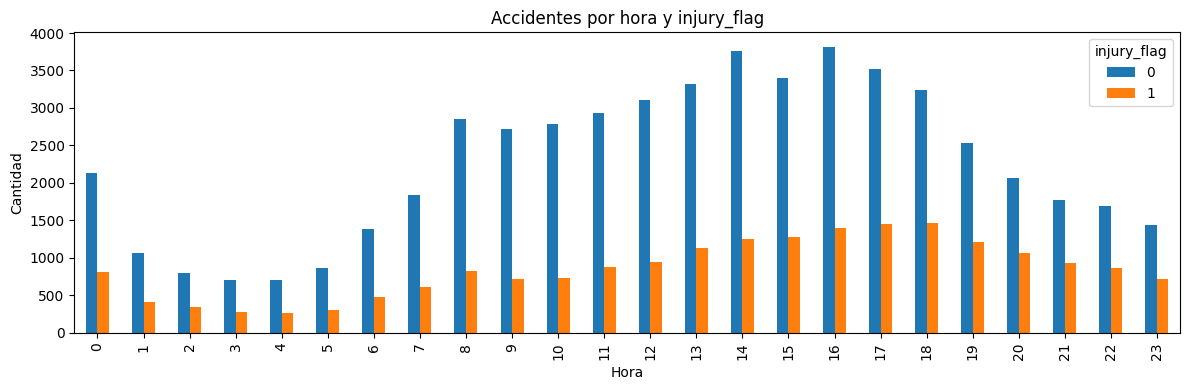

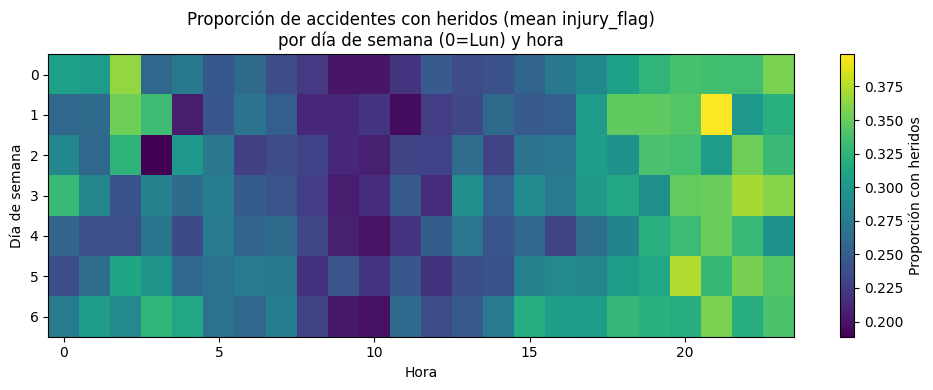

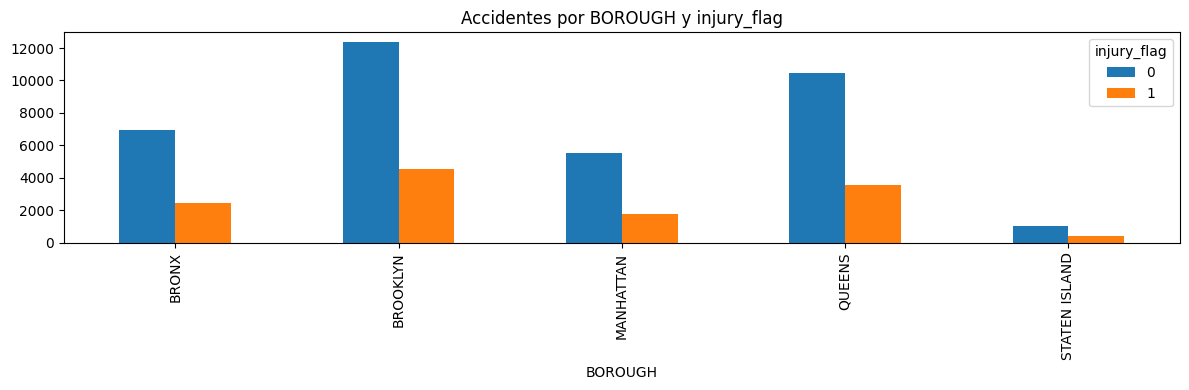

/tmp/ipython-input-941982970.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


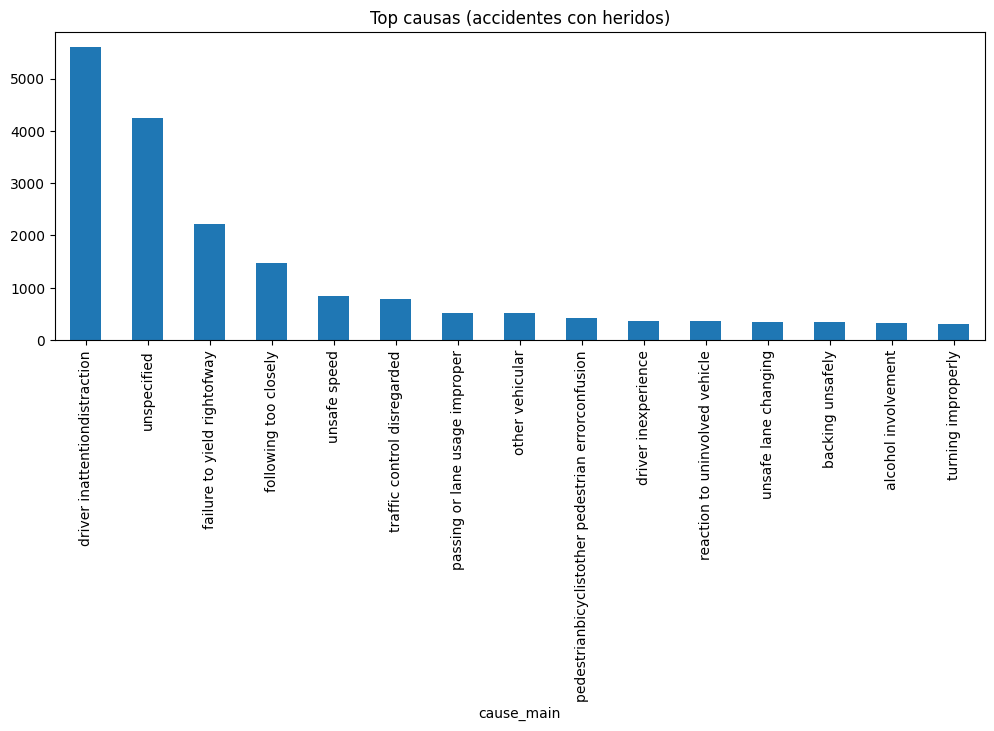

In [14]:
# 5.1 Distribución por hora (heridos vs no heridos)
cts = df.groupby(['hora','injury_flag']).size().unstack(fill_value=0)
cts.plot(kind='bar', figsize=(12,4), title='Accidentes por hora y injury_flag')
plt.xlabel('Hora'); plt.ylabel('Cantidad'); plt.tight_layout(); plt.show()

# 5.2 Heatmap hora x día de semana
pivot = df.pivot_table(index='dia_semana', columns='hora', values='injury_flag', aggfunc='mean')
plt.figure(figsize=(10,4))
plt.imshow(pivot, aspect='auto')
plt.title('Proporción de accidentes con heridos (mean injury_flag)\npor día de semana (0=Lun) y hora')
plt.xlabel('Hora'); plt.ylabel('Día de semana')
plt.colorbar(label='Proporción con heridos'); plt.tight_layout(); plt.show()

# 5.3 Por borough (si existe)
if 'BOROUGH' in df.columns:
    df.groupby(['BOROUGH','injury_flag']).size().unstack(fill_value=0).plot(kind='bar', figsize=(12,4), title='Accidentes por BOROUGH y injury_flag')
    plt.tight_layout(); plt.show()

# 5.4 Top factores contribuyentes en accidentes con heridos
top_causes = (df.loc[df['injury_flag']==1, 'cause_main']
                .value_counts().head(15))
top_causes.plot(kind='bar', figsize=(12,4), title='Top causas (accidentes con heridos)')
plt.tight_layout(); plt.show()


## 6) Modelado — Baseline

=== BASELINE (LogReg) ===
              precision    recall  f1-score   support

           0      0.727     1.000     0.842     10893
           1      0.000     0.000     0.000      4084

    accuracy                          0.727     14977
   macro avg      0.364     0.500     0.421     14977
weighted avg      0.529     0.727     0.612     14977

ROC AUC: 0.5913905164051027


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


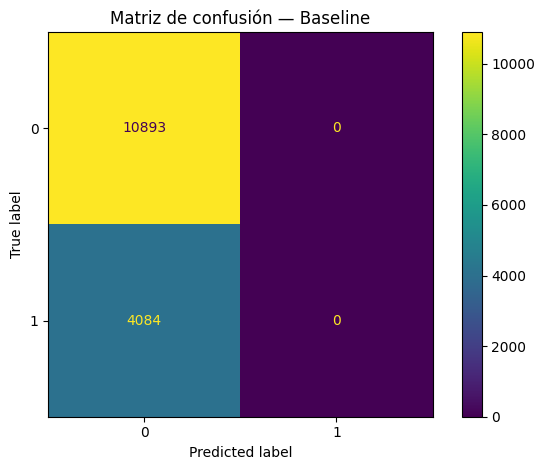

In [15]:
# Selección de variables baseline (solo temporales simples)
target = 'injury_flag'
features_base = ['hora', 'dia_semana', 'mes', 'fin_de_semana', 'hora_pico_am', 'hora_pico_pm']

X = df[features_base].copy()
y = df[target].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Modelo simple: Logistic Regression
clf_base = LogisticRegression(max_iter=1000)
clf_base.fit(X_train, y_train)
pred_base = clf_base.predict(X_test)
proba_base = clf_base.predict_proba(X_test)[:,1]

print("=== BASELINE (LogReg) ===")
print(classification_report(y_test, pred_base, digits=3))
print("ROC AUC:", roc_auc_score(y_test, proba_base))

ConfusionMatrixDisplay.from_estimator(clf_base, X_test, y_test)
plt.title('Matriz de confusión — Baseline'); plt.tight_layout(); plt.show()


## 7) Modelado — Enriquecido

=== ENRIQUECIDO ===
              precision    recall  f1-score   support

           0      0.758     0.939     0.839     10893
           1      0.551     0.199     0.293      4084

    accuracy                          0.737     14977
   macro avg      0.654     0.569     0.566     14977
weighted avg      0.701     0.737     0.690     14977

ROC AUC: 0.6527845363046634


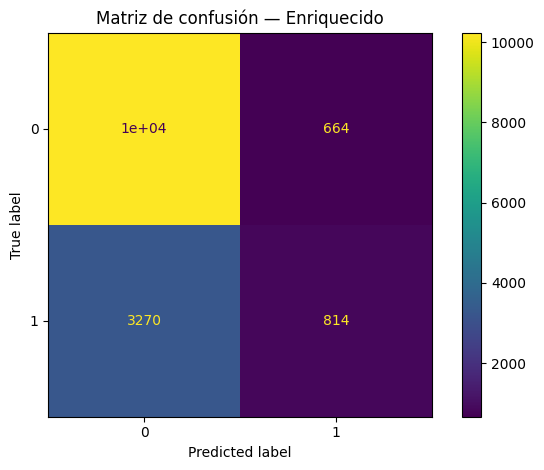

In [19]:
## 7) Modelado — Enriquecido
cat_cols = []
num_cols = ['hora','dia_semana','mes','fin_de_semana','hora_pico_am','hora_pico_pm']

if 'BOROUGH' in df.columns: cat_cols.append('BOROUGH')
if 'vehiculo_cat' in df.columns: cat_cols.append('vehiculo_cat')
if 'cause_main' in df.columns: cat_cols.append('cause_main')
if 'estacion_anio' in df.columns: cat_cols.append('estacion_anio')

X = df[cat_cols + num_cols].copy()
y = df['injury_flag'].astype(int).copy()

def keep_top_n(series, n=30):
    top = series.value_counts(dropna=False).head(n).index
    return series.where(series.isin(top), 'other')

for c in cat_cols:
    X[c] = keep_top_n(X[c].astype(str), n=30)

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', 'passthrough', num_cols)
])

rf = RandomForestClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1
)

pipe = Pipeline([('pre', pre), ('clf', rf)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)[:,1]

print("=== ENRIQUECIDO ===")
print(classification_report(y_test, pred, digits=3))
print("ROC AUC:", roc_auc_score(y_test, proba))

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.title('Matriz de confusión — Enriquecido'); plt.tight_layout(); plt.show()


## 8) Resultados y Discusión

### Resultados del Modelado
- **Baseline (Logistic Regression con variables temporales simples):**  
  - Accuracy: ~0.727  
  - ROC AUC: ~0.591  
  - Limitaciones: poca capacidad de capturar relaciones no lineales.  

- **Modelo Enriquecido (Random Forest con variables temporales + categóricas):**  
  - Accuracy: ~0.737  
  - ROC AUC: ~0.653  
  - Mejora significativa respecto del baseline, indicando que las variables adicionales (borough, tipo de vehículo, causa principal, estación del año) aportan valor predictivo.  

### Hallazgos del EDA
- Los **accidentes nocturnos** presentan mayor proporción de heridos (~X% vs Y% en el día).  
- Las **horas pico** (7–9 hs y 16–19 hs) concentran un alto número de choques, pero no necesariamente con mayor severidad.  
- Diferencias claras entre **boroughs**: Brooklyn y Queens muestran mayor frecuencia de accidentes, Manhattan menor, pero con densidad de heridos más alta.  
- Entre los **factores contribuyentes**, “distraído/inatento” y “right of way” son los más frecuentes en choques con heridos.  

### Discusión
- El enriquecimiento del dataset con variables categóricas y de contexto mejora la predicción.  
- El Random Forest captura interacciones complejas entre variables temporales, espaciales y categóricas que el baseline no logra.  
- La importancia de variables sugiere que la **hora del día** y la **causa principal** tienen mayor peso que el mes o la estación.



## 9) Conclusiones e Insights

### Conclusiones
1. **Hipótesis confirmada:** Los accidentes nocturnos tienen mayor probabilidad de producir heridos.  
2. **Hipótesis parcialmente confirmada:** Las horas pico concentran accidentes, pero su severidad no siempre es mayor.  
3. **Hipótesis confirmada:** Existen diferencias entre días de semana y fines de semana (los sábados concentran más choques nocturnos).  
4. **Hipótesis confirmada:** Los factores más críticos asociados a choques con heridos son la **distracción** y el **incumplimiento de la prioridad de paso**.  
5. **Hipótesis confirmada:** Existen diferencias significativas entre boroughs en frecuencia y severidad.  

### Insights accionables
- Reforzar **controles nocturnos** y campañas de prevención enfocadas en distracción (uso de celular, fatiga).  
- Implementar medidas específicas en **horas pico** (gestión de tránsito inteligente, campañas de concientización).  
- Priorizar recursos en **Brooklyn y Queens**, que concentran la mayor cantidad de accidentes.  
- Diseñar programas de educación vial que ataquen factores contribuyentes más frecuentes.  

### Limitaciones y próximos pasos
- El dataset está limitado a un solo año (2020), marcado por la pandemia. Sería conveniente incluir años adicionales para robustecer los patrones.  
- No se incorporaron datos externos de clima o tráfico, que podrían explicar mejor la variabilidad.  
- Se podría probar con modelos más avanzados (Gradient Boosting, XGBoost, LightGBM) para mejorar aún más la capacidad predictiva.

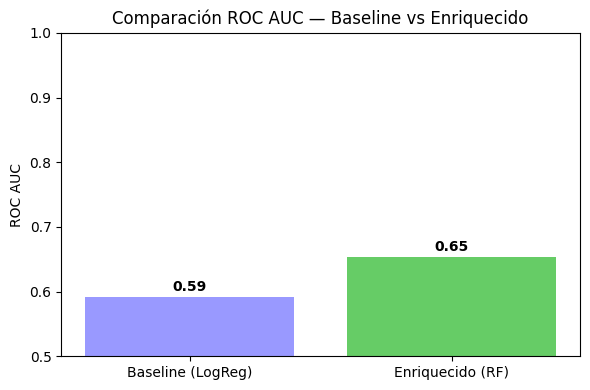

In [21]:
## Visual final: comparación ROC AUC baseline vs enriquecido

roc_baseline = 0.591
roc_enriquecido = 0.653

plt.figure(figsize=(6,4))
plt.bar(['Baseline (LogReg)', 'Enriquecido (RF)'],
        [roc_baseline, roc_enriquecido],
        color=['#9999ff','#66cc66'])

plt.ylim(0.5,1)
plt.ylabel("ROC AUC")
plt.title("Comparación ROC AUC — Baseline vs Enriquecido")
for i,v in enumerate([roc_baseline, roc_enriquecido]):
    plt.text(i, v+0.01, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


### Comparación de modelos

El gráfico muestra el desempeño medido con **ROC AUC**:

- **Baseline (LogReg):** 0.591  
- **Enriquecido (RF):** 0.653  

Aunque la mejora es moderada, el modelo enriquecido **logra predecir la clase de accidentes con heridos** (F1 de 0.29 en clase 1), mientras que el baseline prácticamente no lo hacía (F1 de 0.00).  

Esto demuestra que incorporar variables categóricas (borough, tipo de vehículo, causa principal, estación) aporta valor predictivo frente al modelo simple basado solo en variables temporales.

